In [1]:
#https://keras.io/examples/vision/image_classification_from_scratch/
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
tf.config.set_visible_devices([], 'GPU')

In [2]:
import pathlib 
import os
base_dir = pathlib.Path('..')
data_train = base_dir / 'data' / 'train'
print(len(os.listdir(data_train)), os.listdir(data_train)[0])
target_classes = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
def make_target_train_classes():
    for target_cls in target_classes:
        if os.path.exists(data_train / target_cls):
            print(f'path {data_train/target_cls} exists')
            print(target_cls, len(os.listdir(data_train / target_cls)))
        else: 
            os.makedirs(data_train / target_cls)
            print(f'path {data_train/target_cls} created')
# make_target_train_classes()

6 cardboard


In [3]:
from tqdm import tqdm 
def calculate_valid_images():
    num_skipped = 0 
    for target_cl in target_classes:
        print(target_cl)
        for file_path in tqdm(os.listdir(data_train / target_cl)):
            try:
                fobj = open(data_train / target_cl / file_path, 'rb')
                is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
            finally:
                fobj.close()
            if is_jfif is None:
                num_skipped += 1
    return num_skipped
# calculate_valid_images()

In [4]:
def move_images(): 
    # copy files to train folder classes folder 
    for img_file in tqdm(os.listdir(data_train)):
        if img_file.endswith('.jpg'):
            img_path = data_train / img_file
            for target_cls in target_classes:
                if img_file.startswith(target_cls):
                    img_path.rename(data_train / target_cls / img_file)
                    
# move_images()

In [5]:
image_size = (384, 512)#, 3)
batch_size = 8

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    '../data/train',
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_train,
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 1766 files belonging to 6 classes.
Using 1413 files for training.
Found 1766 files belonging to 6 classes.
Using 353 files for validation.


In [6]:
train_ds, val_ds


(<BatchDataset shapes: ((None, 384, 512, 3), (None,)), types: (tf.float32, tf.int32)>,
 <BatchDataset shapes: ((None, 384, 512, 3), (None,)), types: (tf.float32, tf.int32)>)

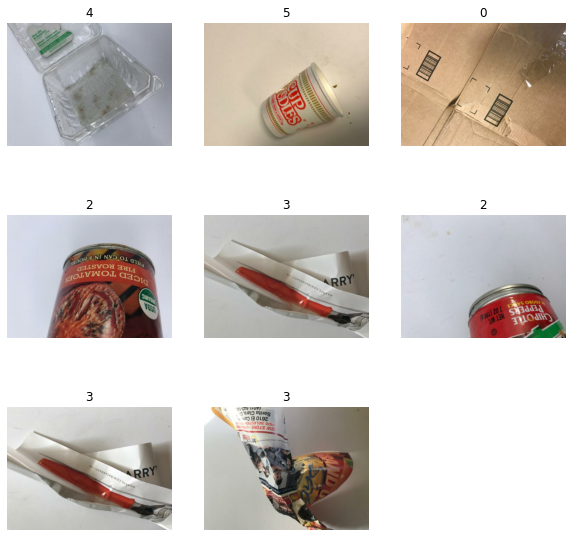

In [7]:
import matplotlib.pyplot as plt

def plot_sample_images():
    plt.figure(figsize=(10, 10))
    for images, labels in train_ds.take(1):
        for i in range(8):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(int(labels[i]))
            plt.axis("off")
plot_sample_images()

In [8]:

def get_data_augmentaion_layer():
    data_augmentation = keras.Sequential(
        [
            layers.RandomFlip("horizontal"),
            layers.RandomRotation(0.1),
        ]
        )
    return data_augmentation

In [9]:
def plot_data_augmentation_examples():
    plt.figure(figsize=(10, 10))
    for images, _ in train_ds.take(1):
        for i in range(9):
            augmented_images = get_data_augmentaion_layer()(images) # data_augmentation(images)
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(augmented_images[0].numpy().astype("uint8"))
            plt.axis("off")
# plot_data_augmentation_examples()

In [13]:
def make_cnn_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    model = keras.Sequential()
    model.add(inputs)
    model.add(layers.Rescaling(1./255))
    # 1 Conv 2d layer  and one dense layer of 512 size
    model.add(layers.Conv2D(32, 3, padding="same", activation="relu", input_shape=input_shape))
    # model.add(layers.Conv2D(64, 3, padding="same", activation="relu"))
    # model.add(layers.Conv2D(64, 3, padding="same", activation="relu"))
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation="relu"))
    model.add(layers.Dense(num_classes, activation="softmax"))
    return model 

def make_nn_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    model = keras.Sequential()
    model.add(inputs)
    model.add(layers.Rescaling(1./255))
    # 1 dense layer of 512 size
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation="relu"))
    model.add(layers.Dense(num_classes, activation="softmax"))
    return model 

In [14]:
model = make_nn_model(input_shape=image_size + (3,), num_classes=len(target_classes))
model.build()
model.summary()

# keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 384, 512, 3)       0         
                                                                 
 flatten_1 (Flatten)         (None, 589824)            0         
                                                                 
 dense_2 (Dense)             (None, 512)               301990400 
                                                                 
 dense_3 (Dense)             (None, 6)                 3078      
                                                                 
Total params: 301,993,478
Trainable params: 301,993,478
Non-trainable params: 0
_________________________________________________________________


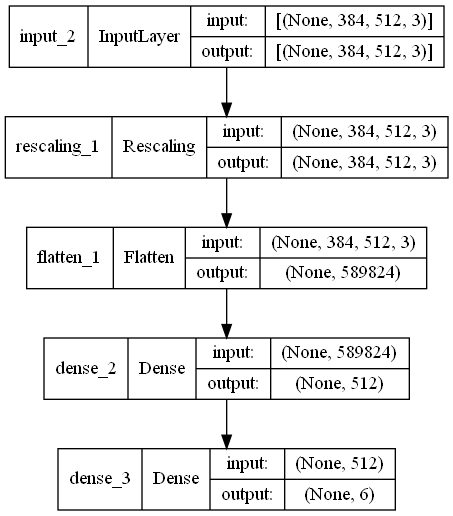

In [15]:
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
epochs = 50

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

In [16]:

def make_xception_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    #x = data_augmentation(inputs)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)#(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


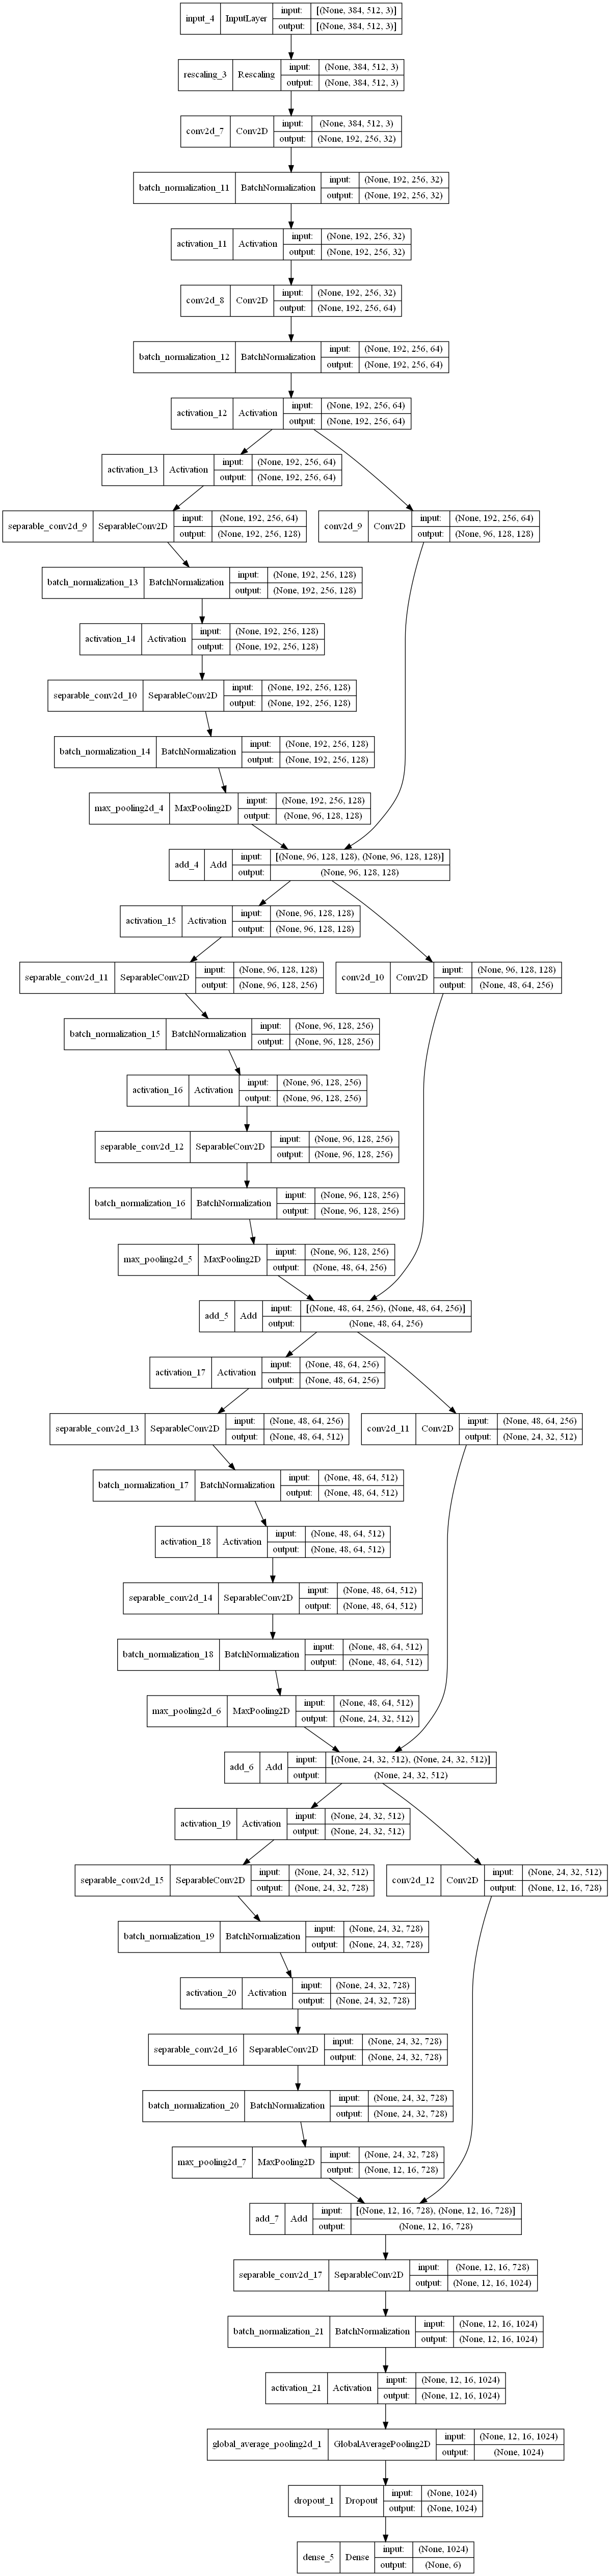

In [18]:
model = make_xception_model(input_shape=image_size + (3,), num_classes=len(target_classes))
#model.summary()
keras.utils.plot_model(model, show_shapes=True)

# Keras Tuner for model optimization 